In [55]:
import pathlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch 

import relso
from relso import data as hdata
from relso.utils import model_utils
from relso.nn.models import relso1


%matplotlib inline

ModuleNotFoundError: No module named 'phate'

# Load Data

In [2]:
proto_data = hdata.str2data('gifford')
data = proto_data(data_dir='../data/', dataset='gifford')

loading data from: ../data/
train/test sizes: (67769, 22690)
seq len: 20
setting up task: recon
split sizes
train: 57603
valid: 10166
setting up splits
setting up test split


In [3]:
trainset_seqs = data.train_split.tensors[0]
print(trainset_seqs.shape)

torch.Size([57603, 20])


In [4]:
trainset_fitness = data.train_split.tensors[-1]
print(trainset_fitness.shape)

torch.Size([57603])


# Load Relso model

In [5]:
# path to weights
relso_weight_path = model_utils.weight_path_from_json(json_path='../relso_model_weights/trained_models.json',
                           weight_dir='../relso_model_weights/trained_models',
                          dataset='gifford',
                          model='all')
print(relso_weight_path)

../relso_model_weights/trained_models/2021-06-22-16-59-23_model_weights.ckpt


In [6]:
relso_model = relso1.load_from_checkpoint(relso_weight_path)
relso_model = relso_model.eval()


/Users/ec_lab/opt/anaconda3/envs/relsoenv/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/migration.py:195: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
Lightning automatically upgraded your loaded checkpoint from v1.0.3 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../relso_model_weights/trained_models/2021-06-22-16-59-23_model_weights.ckpt`


[Linear(in_features=30, out_features=4000, bias=True), Block(
  (skip): Sequential(
    (0): Conv1d(200, 400, kernel_size=(1,), stride=(1,), bias=False)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block): Sequential(
    (0): Conv1d(200, 400, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(400, 400, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (4): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
), Conv1d(400, 22, kernel_size=(3,), stride=(1,), padding=(1,))]


# Get Embeddings

In [7]:
train_loader = data.train_dataloader(shuffle_bool=False)

In [8]:
trainset_embeds = []
trainset_ypreds = []

In [9]:
with torch.no_grad():
    for x in tqdm(train_loader):
        embed = relso_model.encode(x[0])
        ypred = relso_model.predict_fitness_from_z(embed)
        trainset_embeds.append(embed)
        trainset_ypreds.append(ypred)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 577/577 [02:38<00:00,  3.64it/s]


In [10]:
trainset_embeds_tensor = torch.cat(trainset_embeds)
trainset_ypreds_tensor = torch.cat(trainset_ypreds)

In [11]:
print(f'trainset_embeds_tensor: {trainset_embeds_tensor.shape}')
print(f'trainset_ypreds_tensor: {trainset_ypreds_tensor.shape}')

trainset_embeds_tensor: torch.Size([57603, 30])
trainset_ypreds_tensor: torch.Size([57603, 1])


# Plot Embeddings

In [12]:
train_relso_pca_coords = PCA(n_components=2).fit_transform(trainset_embeds_tensor.numpy())

In [13]:
print(train_relso_pca_coords.shape)

(57603, 2)


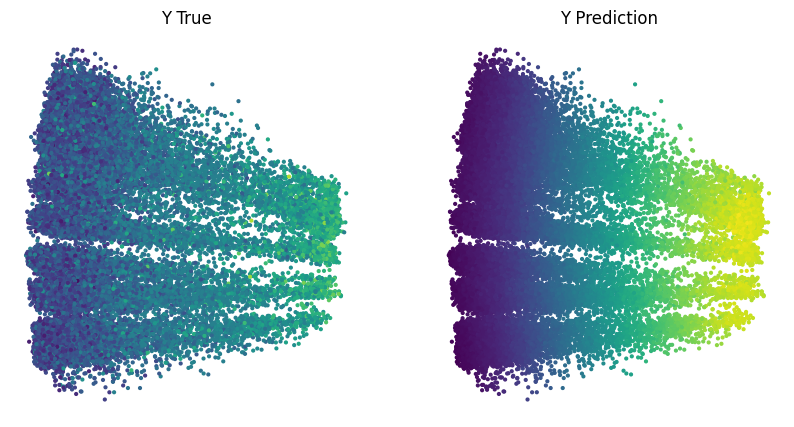

In [25]:
fig, ax = plt.subplots(1,2,figsize=(10,5),
                       dpi=100)


ax[0].title.set_text('Y True')
ax[0].scatter(train_relso_pca_coords[:,0], 
           train_relso_pca_coords[:,1],
           c= trainset_fitness, s=4)

ax[0].axis('off')

ax[1].title.set_text('Y Prediction')
ax[1].scatter(train_relso_pca_coords[:,0], 
           train_relso_pca_coords[:,1],
           c= trainset_ypreds_tensor, s=4)
ax[1].axis('off')

plt.show()

# Attention

In [15]:
x_sample = [trainset_seqs[i].reshape(1,-1) for i in torch.argsort(trainset_fitness, descending=True)[:5000]]
x_sample = torch.cat(x_sample)
print(x_sample.shape)

torch.Size([5000, 20])


In [16]:
with torch.no_grad():
    x_embed = relso_model.embed(x_sample)

In [17]:
with torch.no_grad():
    x_maps = relso_model.transformer_encoder.get_attention_maps(x_embed)

In [18]:
with torch.no_grad():
    x_glob_attn = relso_model.glob_attn_module(x_embed)

### Global Attention

In [19]:
glob_attn_list = [x.reshape(-1,1) for x in x_glob_attn.squeeze().T]

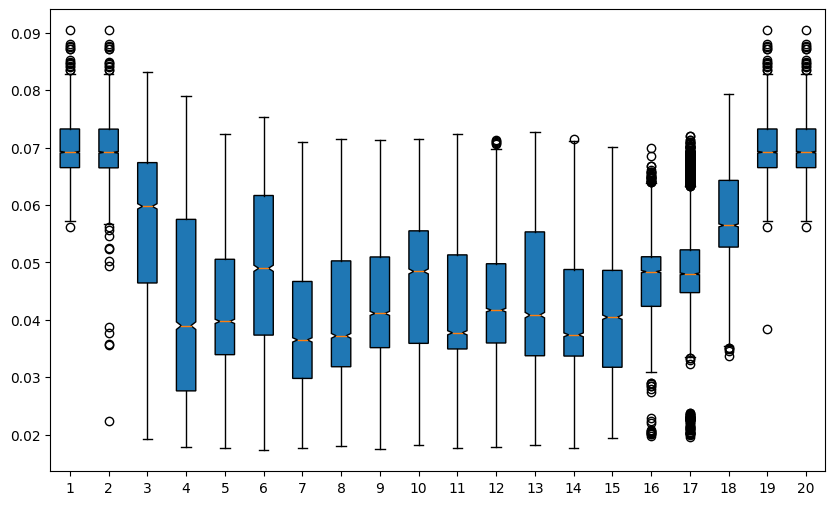

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(x_glob_attn.squeeze().T, notch=True, patch_artist=True)
# plt.xticks(np.arange(100), ["Free sulfur dioxide", "Total sulfur dioxide"])
plt.show()

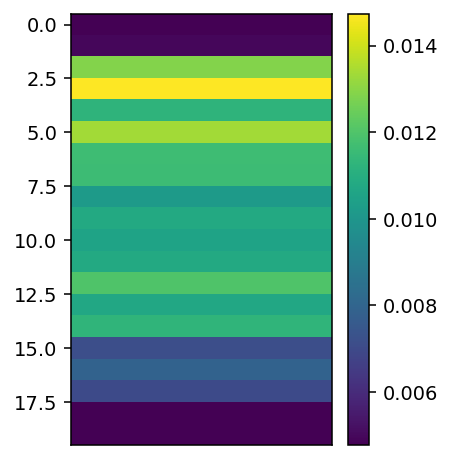

In [22]:
fig, ax = plt.subplots(figsize=(3,4), dpi=140)

x = np.arange(20)
y = torch.std(x_glob_attn.squeeze(), dim=0)


im = ax.imshow(y.reshape(-1,1), aspect='auto')
plt.xticks([], [])

plt.colorbar(im)

plt.show()

## Attention Maps

In [28]:
map_list = [x.unsqueeze(0) for x in x_maps]
x_map_all = torch.cat(map_list)
print(x_map_all.shape)

torch.Size([10, 5000, 4, 20, 20])


### Dimensions
- dim 0: number of layers (10)
- dim 1: number of samples (5000)
- dim 2: number of heads (4)
- dim 3: sequence length
- dim 4: sequence length

In [41]:
x_map_all = x_map_all.transpose(0,1)
print(x_map_all.shape)

torch.Size([5000, 10, 4, 20, 20])


In [44]:
one_ex_maps = x_map_all[0]
one_ex_maps = one_ex_maps.reshape(-1,20,20)
print(one_ex_maps.shape)

torch.Size([40, 20, 20])


In [45]:
one_ex_maps.shape

torch.Size([40, 20, 20])

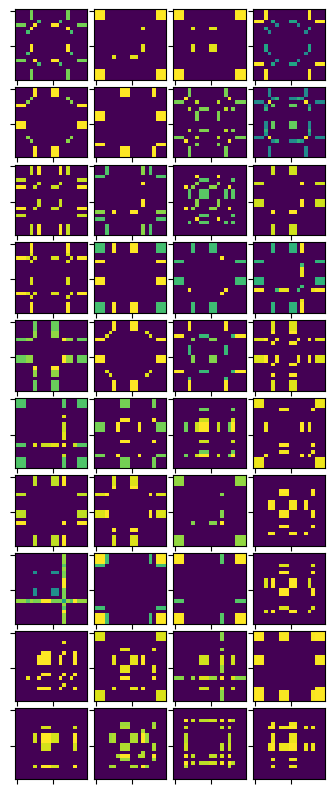

In [46]:
fig, ax = plt.subplots(10,4, figsize=(4,10))

for i, x in enumerate(one_ex_maps):
    
    x = x + x.T
#     x = x.n
    q = np.quantile(x, 0.90)
    x[x < q] = 0
#     x = torch.triu(x)
    i_indx = i // 4
    j_indx = i % 4
    
    ax[i_indx, j_indx].set_xticklabels([])
    ax[i_indx, j_indx].set_yticklabels([])
#     ax[i_indx, j_indx].set_aspect('equal')
    ax[i_indx, j_indx].imshow(x.numpy(), aspect='auto')
#     ax[i_indx, j_indx].axis('off')
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)


In [52]:
x_map_sum = x_map_sum.sum(0).sum(0)

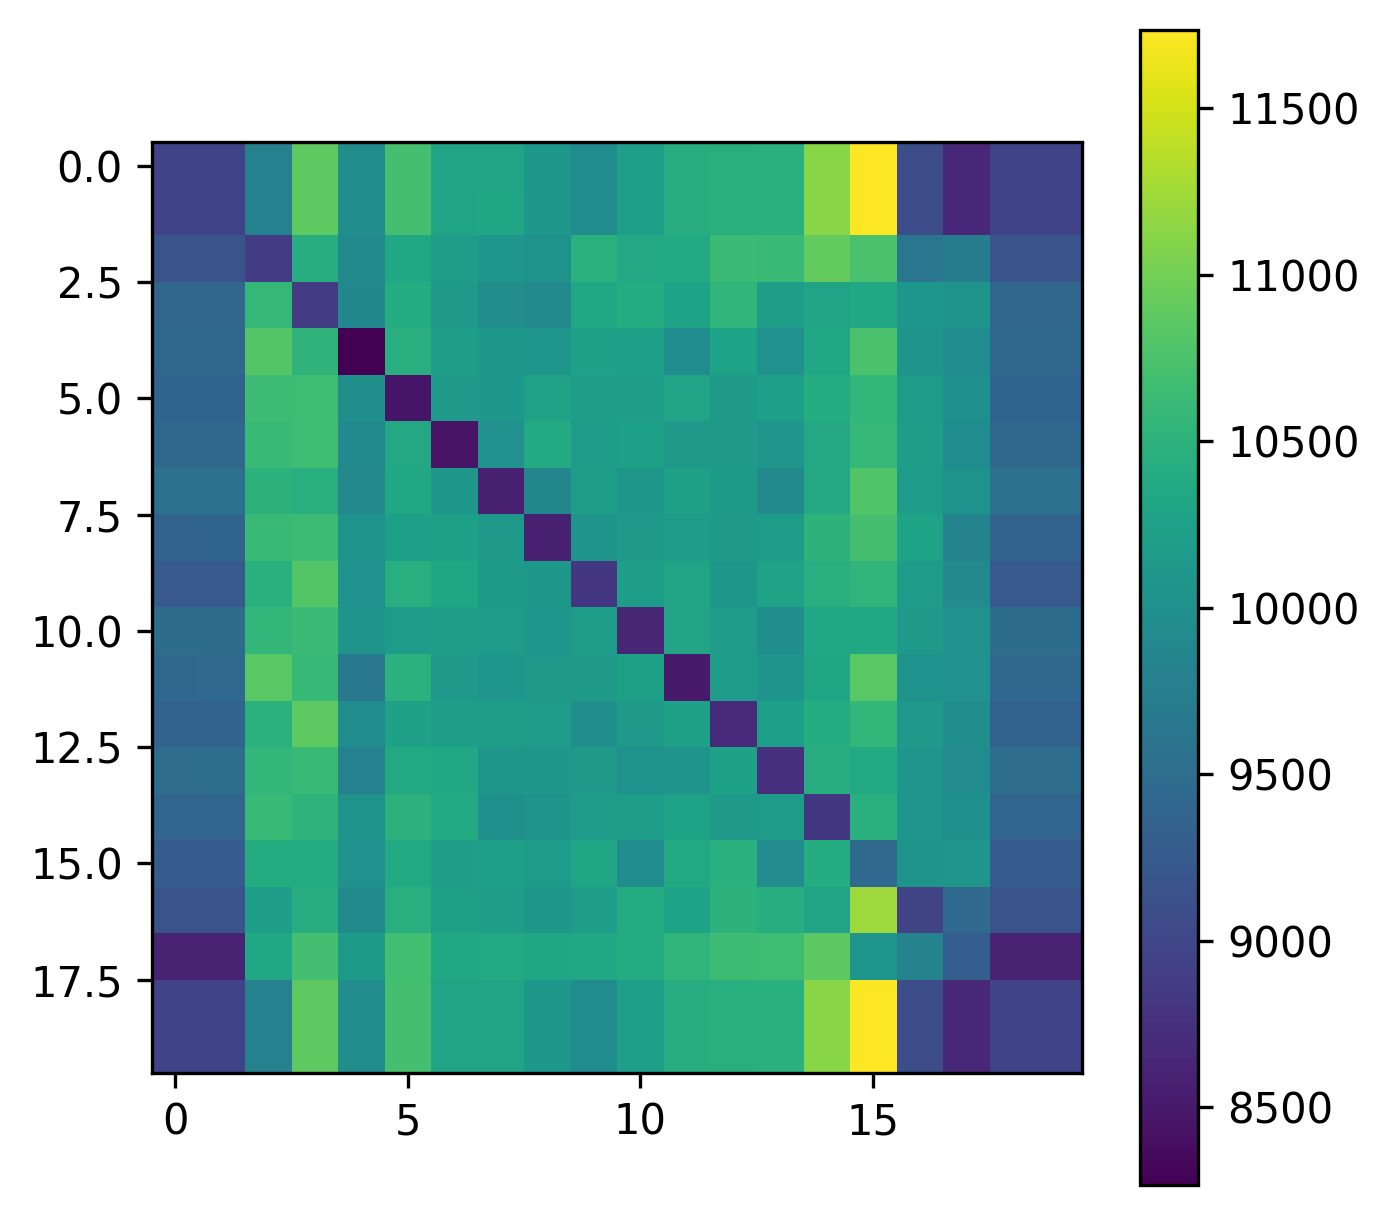

In [53]:
fig, ax = plt.subplots(figsize=(5,5), dpi=300)

im = ax.imshow(x_map_sum.numpy())

plt.colorbar(im)

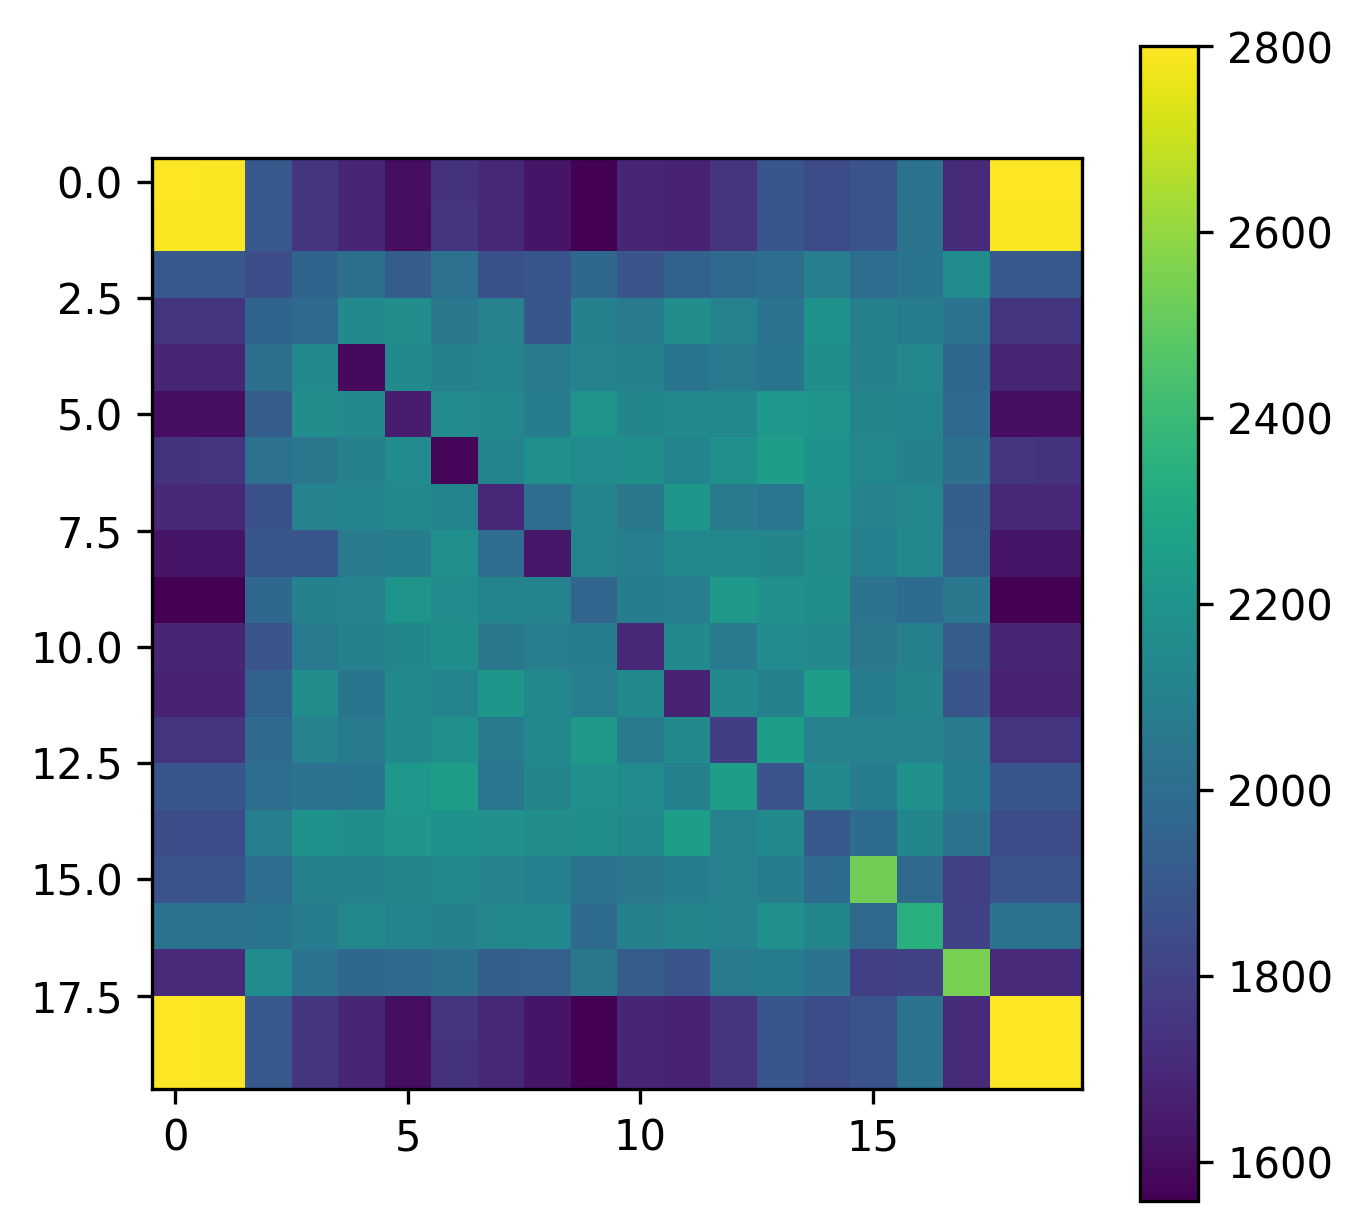

In [54]:
one_attn_map = x_maps[0].sum(0).sum(0)
one_attn_map = one_attn_map + one_attn_map.T
fig, ax = plt.subplots(figsize=(5,5), dpi=300)

im = ax.imshow(one_attn_map.numpy())

plt.colorbar(im)